# <span style="color:#35BCE9">Sandbox</span>
Main Objective: <em>Simple, working, command-line based iteration of GAN Image Generator</em>
<br/><br/>
<u>Inputs</u><br/>
Train images, both true and imposter
<br/><br/>
<u>Outputs</u><br/>
Generated image mimicking true

## <span style="color:#35BCE9">Phase I: Load Train Images</span>

#### Imports

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

import torchvision
from torchvision import transforms

In [2]:
import cv2
import glob
import time

In [3]:
# Image Directory
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
image_dir = os.path.join(parent_dir, 'Images')
os.listdir(image_dir)

['TestImages', '.DS_Store', 'ResultImages', 'TrainingImages']

#### PyTorch Data Handling

In [4]:
class ImageDataset(Dataset):
    def __init__(self, imagePaths):
        # data loading
        self.imagePaths = imagePaths
        self.TARGET_HEIGHT = 256
        self.TARGET_WIDTH = 256

    def __len__(self):
        # len()
        return len(self.imagePaths)

    def __getitem__(self, idx):
        # indexing
        image = cv2.imread(self.imagePaths[idx])
        imageRgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resizedImage = self.resizeImage(imageRgb)
        float32Image = torch.tensor(resizedImage, dtype=torch.float32)
        imageTensor = float32Image.permute(2, 0, 1) / 255.0 # Normalize
        #finalTensor = imageTensor.unsqueeze(0)
        return imageTensor # [1, 3, 256, 256]
    
    def resizeImage(self, image):
        # resize to target width and height
        image = cv2.resize(image, (self.TARGET_WIDTH, self.TARGET_HEIGHT))
        height, width = image.shape[:2]
        
        # Pad image if below the target size
        top = bottom = (self.TARGET_HEIGHT - height) // 2
        left = right = (self.TARGET_WIDTH - width) // 2

        # Apply padding 
        paddedImage = cv2.copyMakeBorder(
            image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0)
        )

        return paddedImage

    def showImage(self, idx):
        imageTensor = self[idx]
        np_image = imageTensor.detach().cpu().numpy()
        if np_image.ndim == 3 and np_image.shape[0] == 3: # Check if it's a 3-channel image
            np_image = np.transpose(np_image, (1, 2, 0))

        plt.imshow(np_image)
        plt.axis('off') # Turn off axis labels and ticks
        plt.show()

In [5]:
imageFolder = f"{image_dir}/TrainingImages/Goth"
imagePaths = glob.glob(f"{imageFolder}/*.jpg") + glob.glob(f"{imageFolder}/*.png")

dataset = ImageDataset(imagePaths=imagePaths)

In [6]:
len(imagePaths)

91

In [7]:
imageFolder

'/Users/andrewturangan/Local/GanAnime/Images/TrainingImages/Goth'

In [8]:
dataset[0]

tensor([[[0.8510, 0.8510, 0.8588,  ..., 0.8392, 0.8431, 0.8314],
         [0.8314, 0.8588, 0.8824,  ..., 0.8157, 0.8588, 0.8275],
         [0.7882, 0.8000, 0.8314,  ..., 0.9294, 0.9255, 0.7608],
         ...,
         [0.7490, 0.7569, 0.7686,  ..., 0.8353, 0.8314, 0.8392],
         [0.7647, 0.7804, 0.7843,  ..., 0.8275, 0.8314, 0.8314],
         [0.8118, 0.8118, 0.8118,  ..., 0.8314, 0.8314, 0.8314]],

        [[0.8549, 0.8627, 0.8627,  ..., 0.8510, 0.8549, 0.8471],
         [0.8353, 0.8588, 0.8706,  ..., 0.8078, 0.8510, 0.8392],
         [0.7843, 0.7294, 0.7529,  ..., 0.8510, 0.8353, 0.7647],
         ...,
         [0.7490, 0.7490, 0.7529,  ..., 0.8471, 0.8431, 0.8510],
         [0.7686, 0.7725, 0.7804,  ..., 0.8392, 0.8431, 0.8510],
         [0.8118, 0.8118, 0.8118,  ..., 0.8471, 0.8431, 0.8510]],

        [[0.8706, 0.8784, 0.8784,  ..., 0.8706, 0.8745, 0.8667],
         [0.8510, 0.8627, 0.8627,  ..., 0.7843, 0.8392, 0.8588],
         [0.7804, 0.6431, 0.6549,  ..., 0.7451, 0.7294, 0.

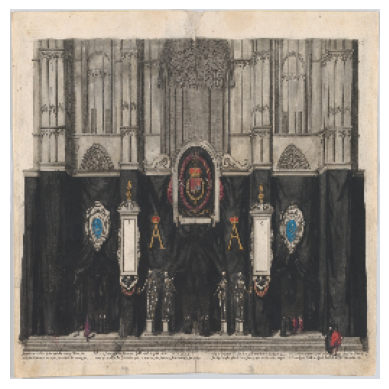

In [9]:
dataset.showImage(0)

#### Train \& Test Image Dataset

In [10]:
trainFolder = f"{image_dir}/TrainingImages/Goth"
imagePaths = glob.glob(f"{trainFolder}/*.jpg") + glob.glob(f"{trainFolder}/*.png")
trainDataset = ImageDataset(imagePaths=imagePaths)

testFolder = f"{image_dir}/TestImages/Goth"
imagePaths = glob.glob(f"{testFolder}/*.jpg") + glob.glob(f"{testFolder}/*.png")
testDataset = ImageDataset(imagePaths=imagePaths)

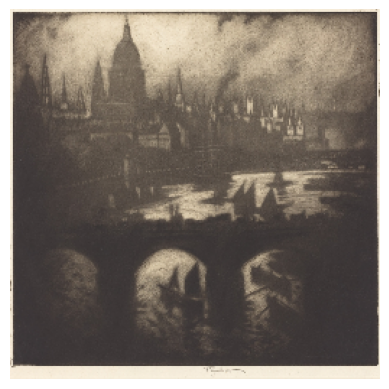

In [11]:
testDataset.showImage(0)

#### DataLoader

In [12]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=1, shuffle=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=1, shuffle=True)

## <span style="color:#35BCE9">Phase II: Build GAN</span>

In [13]:
class Gan():
    def InitializeParameters(self, trainDataLoader, testDataLoader):
        self.INIT_LR = 2e-4
        self.BATCH_SIZE = 32
        self.EPOCHS = 50
        self.W_REG = 0.004
        
        self.lossD = None
        self.lossG = None
        self.randTorch = None
        
        self.trainDataLoader = trainDataLoader
        self.testDataLoader = testDataLoader
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        
        self.GenCnn = GenCnn(100, 3).to(self.device)
        self.GraderCnn = GraderCnn(3).to(self.device)
        
        self.lossBce = nn.BCELoss()
        self.optG = Adam(self.GenCnn.parameters(), lr=self.INIT_LR, betas=(0.5, 0.999))
        self.optD = Adam(self.GraderCnn.parameters(), lr=self.INIT_LR, betas=(0.5, 0.999))
        
    
    def TrainNn(self):
        print("Using ", self.device, "for training")
        print("Start Training...")
        
        startTime = time.time()
        
        # Training
        for i in range(self.EPOCHS):
            for self.realImages in self.trainDataLoader:
                self.realImages = self.realImages.to(self.device)
                self.batchSize = self.realImages.size(0)
                
                self.realLabels = torch.ones(self.batchSize, 1, 1, 1, device=self.device)
                self.fakeLabels = torch.zeros(self.batchSize, 1, 1, 1, device=self.device)

                self.__TrainGraderNn()
                self.__TrainGeneratorNn()
            
            print(f"Epoch [{i+1}/{self.EPOCHS}] | D Loss: {self.lossD.item():.4f} | G Loss: {self.lossG.item():.4f}")

            # Save sample of generated images
            if (i + 1) % 10 == 0:
                plt.figure(figsize=(5,5))
                with torch.no_grad():
                    sampleImages = self.GenCnn(torch.randn(16, 100, 1, 1, device=self.device)).cpu()
                sampleImages = (sampleImages + 1) / 2  # Rescale to [0,1]
                grid = torchvision.utils.make_grid(sampleImages, nrow=4)
                plt.imshow(grid.permute(1, 2, 0))
                plt.show()
        
        totalTime = time.time()-startTime
    
        print('Total Training Time: ', round(totalTime, 2), ' seconds\n')

    def GenerateImages(self, num_images=1, show=True) -> torch.Tensor:
        self.GenCnn.eval()

        # latent vectors
        z = torch.randn(num_images, 100, 1, 1, device=self.device)

        with torch.no_grad():
            sample_images = self.GenCnn(z)
            
        # move to CPU and rescale from [-1,1] → [0,1]
        sample_images = (sample_images.cpu() + 1) / 2
        sample_images = sample_images.clamp(0, 1)

        if show:
            grid = torchvision.utils.make_grid(sample_images, nrow=int(num_images**0.5))
            plt.figure(figsize=(5, 5))
            plt.imshow(grid.permute(1, 2, 0))
            plt.axis("off")
            plt.show()
    
        self.GenCnn.train()
        return sample_images

    def SaveModel(self, path="gan.pth") -> None:
        checkpoint = {
            "gen_state_dict": self.GenCnn.state_dict(),
            "disc_state_dict": self.GraderCnn.state_dict(),
            "optG_state_dict": self.optG.state_dict(),
            "optD_state_dict": self.optD.state_dict(),
            "z_dim": 100,
            "image_channels": 3
        }
        torch.save(checkpoint, path)
        print(f"Model saved to {path}")

    def LoadModel(self, path="gan.pth") -> None:
        checkpoint = torch.load(path, map_location=self.device)
    
        # Recreate models (important!)
        self.GenCnn = GenCnn(
            zDim=checkpoint["z_dim"],
            imageChannels=checkpoint["image_channels"]
        ).to(self.device)
    
        self.GraderCnn = GraderCnn(
            imageChannels=checkpoint["image_channels"]
        ).to(self.device)
    
        # Load weights
        self.GenCnn.load_state_dict(checkpoint["gen_state_dict"])
        self.GraderCnn.load_state_dict(checkpoint["disc_state_dict"])
    
        # Optimizers (optional — only if resuming training)
        self.optG.load_state_dict(checkpoint["optG_state_dict"])
        self.optD.load_state_dict(checkpoint["optD_state_dict"])
    
        print("Model loaded successfully")

            
    def __TrainGraderNn(self):
        # Train Discriminator
        self.randTorch = torch.randn(self.batchSize, 100, 1, 1, device=self.device)
        self.fakeImages = self.GenCnn(self.randTorch)
        realLoss = self.lossBce(self.GraderCnn(self.realImages), self.realLabels)
        fakeLoss = self.lossBce(self.GraderCnn(self.fakeImages.detach()), self.fakeLabels)
        self.lossD = realLoss + fakeLoss
        
        self.optD.zero_grad()
        self.lossD.backward()
        self.optD.step()
                
    def __TrainGeneratorNn(self):
        # Train Generator
        self.fakeImages = self.GenCnn(self.randTorch)
        self.lossG = self.lossBce(self.GraderCnn(self.fakeImages), self.realLabels)

        self.optG.zero_grad()
        self.lossG.backward()
        self.optG.step()

In [14]:
class GenCnn(Module):
    def __init__(self, zDim=100, imageChannels=3):
        super(GenCnn, self).__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(zDim, 1024, kernel_size=4, stride=1, padding=0),  # 1x1 → 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),  # 4x4 → 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64 → 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, imageChannels, kernel_size=4, stride=2, padding=1),  # 128x128 → 256x256
            nn.Tanh()  # Output is scaled between [-1,1]
        )

    def forward(self, x):
        return self.model(x)

In [15]:
class GraderCnn(Module):
    def __init__(self, imageChannels):
        super(GraderCnn, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(imageChannels, 32, kernel_size=4, stride=2, padding=1),  # 256x256 → 128x128
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 128x128 → 64x64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x64 → 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 32x32 → 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 16x16 → 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # 8x8 → 4x4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0),  # 4x4 → 1x1
            nn.Sigmoid()  # Output probability (real vs. fake)
        )


    def forward(self, x):
        return self.model(x)
    

In [16]:
gan = Gan()
gan.InitializeParameters(trainDataLoader=trainDataLoader, testDataLoader=testDataLoader)

## <span style="color:#35BCE9">Phase III: Train GAN</span>

Using  cpu for training
Start Training...
Epoch [1/50] | D Loss: 0.0027 | G Loss: 10.6984
Epoch [2/50] | D Loss: 2.5666 | G Loss: 1.9128
Epoch [3/50] | D Loss: 0.4948 | G Loss: 4.0856
Epoch [4/50] | D Loss: 1.2562 | G Loss: 7.6675
Epoch [5/50] | D Loss: 1.6863 | G Loss: 4.6151
Epoch [6/50] | D Loss: 1.0686 | G Loss: 1.5667
Epoch [7/50] | D Loss: 0.0329 | G Loss: 7.8276
Epoch [8/50] | D Loss: 0.1947 | G Loss: 4.3268
Epoch [9/50] | D Loss: 1.3983 | G Loss: 2.9181
Epoch [10/50] | D Loss: 1.5501 | G Loss: 0.5219


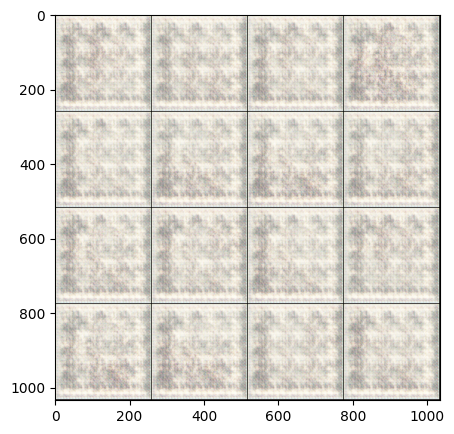

Epoch [11/50] | D Loss: 0.8754 | G Loss: 2.7708
Epoch [12/50] | D Loss: 3.4652 | G Loss: 3.3068
Epoch [13/50] | D Loss: 1.1284 | G Loss: 1.1320
Epoch [14/50] | D Loss: 0.4360 | G Loss: 3.1344
Epoch [15/50] | D Loss: 0.7542 | G Loss: 5.0300
Epoch [16/50] | D Loss: 2.1684 | G Loss: 2.1796
Epoch [17/50] | D Loss: 0.6045 | G Loss: 1.7230
Epoch [18/50] | D Loss: 1.2889 | G Loss: 2.3591
Epoch [19/50] | D Loss: 0.8960 | G Loss: 2.4803
Epoch [20/50] | D Loss: 0.9734 | G Loss: 1.4291


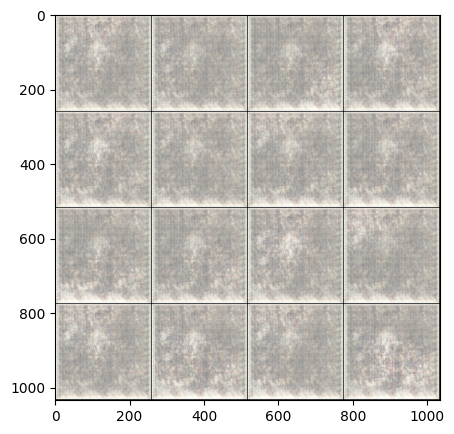

Epoch [21/50] | D Loss: 2.8596 | G Loss: 2.1271
Epoch [22/50] | D Loss: 0.4668 | G Loss: 3.4659
Epoch [23/50] | D Loss: 1.7106 | G Loss: 1.4850
Epoch [24/50] | D Loss: 0.6876 | G Loss: 2.5679
Epoch [25/50] | D Loss: 2.8249 | G Loss: 2.2638
Epoch [26/50] | D Loss: 1.9697 | G Loss: 2.1955
Epoch [27/50] | D Loss: 0.1358 | G Loss: 4.8916
Epoch [28/50] | D Loss: 1.8098 | G Loss: 2.2318
Epoch [29/50] | D Loss: 2.7833 | G Loss: 3.3079
Epoch [30/50] | D Loss: 0.3923 | G Loss: 4.6356


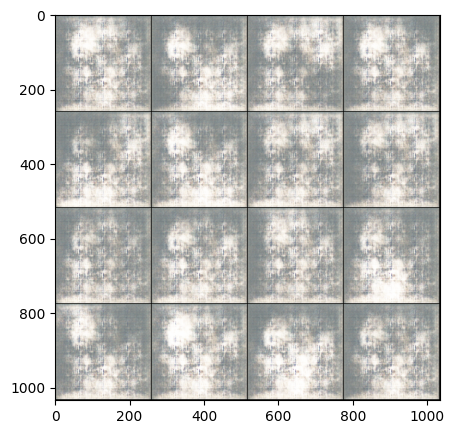

Epoch [31/50] | D Loss: 0.2293 | G Loss: 3.2076
Epoch [32/50] | D Loss: 0.9700 | G Loss: 4.5347
Epoch [33/50] | D Loss: 3.0871 | G Loss: 3.2196
Epoch [34/50] | D Loss: 0.5227 | G Loss: 3.6642
Epoch [35/50] | D Loss: 0.2488 | G Loss: 4.4845
Epoch [36/50] | D Loss: 0.2001 | G Loss: 3.7943
Epoch [37/50] | D Loss: 2.9675 | G Loss: 0.7098
Epoch [38/50] | D Loss: 2.0143 | G Loss: 8.7856
Epoch [39/50] | D Loss: 0.0783 | G Loss: 4.3228
Epoch [40/50] | D Loss: 0.2550 | G Loss: 3.6008


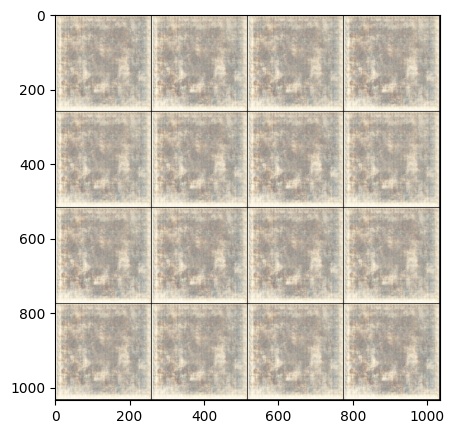

Epoch [41/50] | D Loss: 0.2199 | G Loss: 3.9496
Epoch [42/50] | D Loss: 0.1894 | G Loss: 4.4741
Epoch [43/50] | D Loss: 0.6819 | G Loss: 5.5338
Epoch [44/50] | D Loss: 3.6083 | G Loss: 6.4502
Epoch [45/50] | D Loss: 0.2713 | G Loss: 2.7158
Epoch [46/50] | D Loss: 0.2035 | G Loss: 3.5204
Epoch [47/50] | D Loss: 0.0407 | G Loss: 4.3147
Epoch [48/50] | D Loss: 0.8013 | G Loss: 2.1550
Epoch [49/50] | D Loss: 0.0423 | G Loss: 5.6717
Epoch [50/50] | D Loss: 0.1244 | G Loss: 4.4249


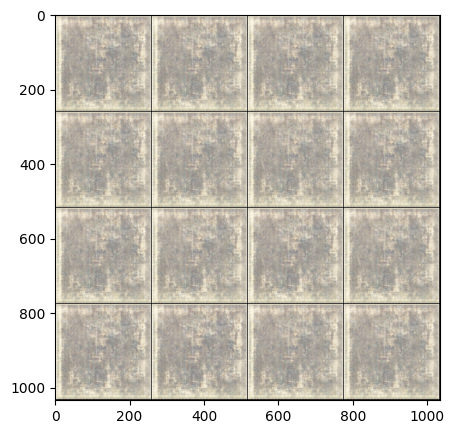

Total Training Time:  949.43  seconds



In [17]:
gan.TrainNn()

## <span style="color:#35BCE9">Phase IV: Generate Images</span>

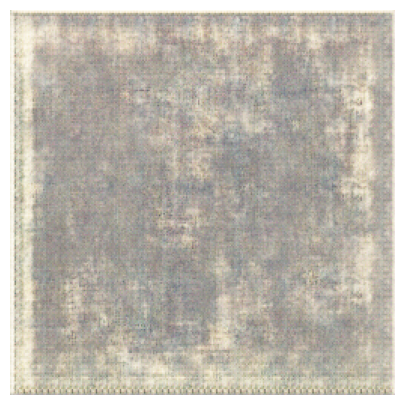

tensor([[[[0.8293, 0.9747, 0.9593,  ..., 0.9808, 0.9502, 0.9453],
          [0.8458, 0.9318, 0.9183,  ..., 0.9378, 0.9457, 0.9526],
          [0.8361, 0.8748, 0.7736,  ..., 0.8276, 0.8739, 0.9538],
          ...,
          [0.9367, 0.9592, 0.9486,  ..., 0.7469, 0.9259, 0.9641],
          [0.8889, 0.9388, 0.8813,  ..., 0.7528, 0.8230, 0.9505],
          [0.7794, 0.8207, 0.7934,  ..., 0.7631, 0.8695, 0.8350]],

         [[0.8384, 0.9466, 0.9554,  ..., 0.9511, 0.9507, 0.8944],
          [0.8660, 0.9112, 0.8531,  ..., 0.8942, 0.8949, 0.9109],
          [0.8046, 0.8515, 0.7802,  ..., 0.8098, 0.8660, 0.9281],
          ...,
          [0.9185, 0.9412, 0.9035,  ..., 0.6658, 0.8785, 0.9345],
          [0.8797, 0.9186, 0.8711,  ..., 0.7311, 0.8504, 0.9259],
          [0.7631, 0.8141, 0.7660,  ..., 0.7457, 0.8297, 0.7944]],

         [[0.7492, 0.9089, 0.8787,  ..., 0.9118, 0.8726, 0.8455],
          [0.7899, 0.8724, 0.7496,  ..., 0.8543, 0.8259, 0.8801],
          [0.7103, 0.8030, 0.6876,  ..., 0

In [18]:
gan.GenerateImages(num_images=1)